In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [4]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import vits_fold as vits, melgan, hifigan
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from malaya_speech.train.loss import calculate_2d_loss, calculate_3d_loss

In [5]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [6]:
wav['wav'].shape

(1, 104448)

In [7]:
config = vits.Config(mel = 80, vocabs = 66)

In [8]:
model = vits.Model(config)

In [9]:
i = tf.convert_to_tensor([data['text_ids'][0],data['text_ids'][0]])
i_lengths = tf.convert_to_tensor([data['len_text_ids'][0,0], data['len_text_ids'][0,0]])
mel_outputs = tf.convert_to_tensor([data['mel'].astype(np.float32)[0],data['mel'].astype(np.float32)[0]])
mel_lengths = tf.convert_to_tensor([408,408])
wavs = tf.convert_to_tensor([wav['wav'].astype(np.float32)] * 2)[:,0]
wavs.shape

TensorShape([Dimension(2), Dimension(104448)])

In [10]:
%%time

losses, attn, latent, z_slice, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths,
                                                             use_revsic = False)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 3.39 s, sys: 564 ms, total: 3.96 s
Wall time: 2.65 s


In [11]:
%%time

mel, mellen, attn_out = model(inputs = i, lengths = i_lengths)
mel, mellen, attn_out

CPU times: user 590 ms, sys: 135 ms, total: 725 ms
Wall time: 368 ms


(<tf.Tensor: id=36772, shape=(2, 150, 80), dtype=float32, numpy=
 array([[[ 3.6184835 ,  0.49546424, -0.96924746, ...,  0.797177  ,
          -0.0847351 , -0.7162268 ],
         [ 0.7370285 , -0.76777565, -0.80583036, ...,  0.14793873,
           1.279865  , -0.1067729 ],
         [ 0.77756   ,  0.4573072 , -0.05324006, ..., -0.09756622,
          -0.18201193, -0.33101127],
         ...,
         [ 0.9221947 , -1.430551  , -0.9383961 , ...,  0.26505783,
           0.7099063 , -1.9157374 ],
         [ 1.3847066 ,  0.8267129 , -1.3298631 , ...,  0.9273416 ,
          -0.01784901, -0.24403465],
         [ 0.98324883, -0.05376661, -0.9717811 , ...,  0.11372778,
           2.189843  , -3.2492375 ]],
 
        [[ 3.7194    ,  0.48294294, -0.8164009 , ...,  0.41561216,
          -0.19862899, -0.7389025 ],
         [ 1.0553272 , -1.4636831 , -0.85838217, ..., -0.17959797,
           1.0506221 , -4.9527025 ],
         [ 2.2506075 ,  0.34732264, -0.01389521, ..., -0.17106178,
          -0.164966

In [19]:
losses

{'kl': <tf.Tensor: id=73745, shape=(), dtype=float32, numpy=1624.3514>,
 'durloss': <tf.Tensor: id=73839, shape=(), dtype=float32, numpy=0.2711231>}

In [20]:
latent.shape

TensorShape([Dimension(2), Dimension(204), Dimension(160)])

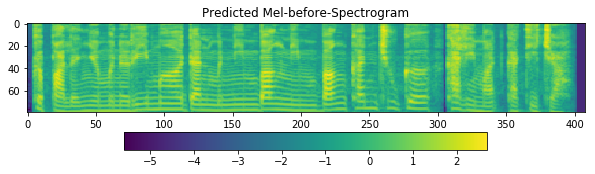

In [21]:
mel_outputs_ = np.reshape(mel_outputs[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

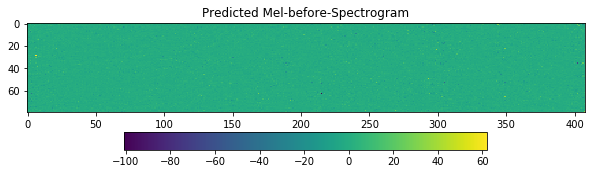

In [22]:
mel_outputs_ = np.reshape(latent[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [23]:
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-5, beta1 = 0.9, 
                                   beta2 = 0.98, epsilon = 1e-9)

In [25]:
for k in range(500):
    with tf.GradientTape() as tape:
        losses, attn, latent, mel_hat, ids_slice = model.compute_loss(text = i, textlen = i_lengths, mel = mel_outputs, mellen = mel_lengths)
        loss = losses['kl'] + losses['durloss']
    print(k, losses)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [27]:
mel_, mellen_, attn_out = model(inputs = i, lengths = i_lengths)
mel_, mellen_, attn_out

(<tf.Tensor: id=1625334, shape=(2, 290, 80), dtype=float32, numpy=
 array([[[-0.50871783, -0.01080999,  0.37902793, ..., -0.8448153 ,
          -0.5762067 , -0.46018744],
         [-0.38429776,  0.70788884, -0.7654651 , ..., -0.5128415 ,
           0.550499  ,  1.0489224 ],
         [ 0.10953857, -0.17839676,  1.0696229 , ...,  1.5987048 ,
          -0.8491666 ,  0.21127772],
         ...,
         [-0.9051129 ,  0.644734  , -0.46192932, ..., -1.4559993 ,
           3.5866213 ,  0.691162  ],
         [-0.74051917, -0.4454509 ,  0.62317157, ..., -0.12701343,
          -0.8372447 ,  0.91102266],
         [-1.0482688 ,  1.0767988 , -0.85963756, ..., -0.5261621 ,
           1.352404  ,  0.92611676]],
 
        [[-0.27296782, -0.91578114, -0.17928195, ..., -0.8134513 ,
          -0.11009096, -1.1084187 ],
         [-0.6267198 ,  1.0716954 ,  0.454562  , ..., -0.5643988 ,
           2.2484977 ,  0.11072879],
         [ 0.20053221,  0.10747906, -0.45884278, ...,  0.7305808 ,
          -0.1166

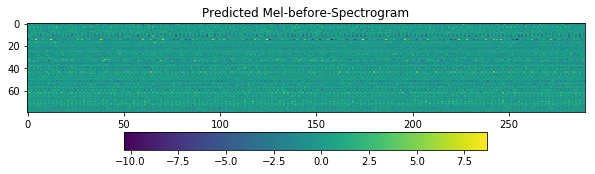

In [28]:
mel_outputs_ = np.reshape(mel_[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    attn_out[0],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

In [ ]:
# saver = tf.train.Saver()
# saver.save(sess, 'test/model.ckpt')